# TebakGaji Notebook

This notebook provides the data cleaning, data exploration, and baseline modeling for the TebakGaji project.

Kindly visit the:
- [Repository](https://github.com/hyperforest/tebakgaji)
- [Streamlit Web App](https://share.streamlit.io/hyperforest/predict_salary_project/main/src/main.py)

First of all, let's include the used libraries.

In [1]:
import os
os.chdir('..')

In [2]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src import constants
from src.tuner import tune_catboost_cv
from src.data import (
    normalize_salary_to_million_idr_monthly,
    read_raw, clean_data, clean_company, clean_country,
    clean_city, clean_role, limit_years_of_exp
)

from scipy.stats import kstest
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import make_scorer, mean_squared_error as mse
from sklearn.model_selection import KFold, cross_val_score
from statannotations.Annotator import Annotator

%load_ext autoreload
%autoreload 2

# Data Schema 🔍

The data source is from [PredictSalary](https://predictsalary.com/salaries). A person submit their salary data through a form and got published with no PII. Go check the submission process and the business model [here](https://predictsalary.com/business-plan).

The schema is as follows.

1. `role`: str. Role/title of the job
2. `company`: str. Not all of the companies are disclosed, only Gojek, Shopee, Tiket.com, Traveloka, Tokopedia, Bukalapak companies are disclosed by default. Undisclosed company is set as `Purchase to unlock 👆`
3. `years_of_exp`: int. Years of experience, ranging from 0 to 20 or more
4. `city`: str. City where the salary owner is living
5. `country`: str. Country code such as "ID", "SG", "MY", "DE"
6. `gender`: str. Male, female, or prefer not to tell
7. `currency`: str. Salary currency code such as "IDR" or "USD"
8. `salary`: int. The salary amount based on the currency and the period
9. `mode`: str. Gross or net salary
10. `period`: str. Monthly or annually paid salary
11. `compensation`: str. Non-cash compensation
12. `verified`: str. Whether the salary owner also attach salary slip during the data submission

In [3]:
DATA_PATH = 'datasets/data.html'

raw_data = read_raw(DATA_PATH)
raw_data.head()

,role,company,years_of_exp,city,country,gender,currency,salary,mode,period,compensation,verified
0,tester,Purchase to unlock 👆,3,Bandung,ID,Male,IDR,30000000,Net,Monthly,RSU so stonks.,Verified
1,HES Engineer,Purchase to unlock 👆,12,Pekanbaru,ID,Male,IDR,54000000,Gross,Monthly,*Vacation allowance = 1 month salary *Full med...,NaN
2,Lead Front End,Purchase to unlock 👆,5,Jakarta,ID,Male,IDR,16500000,Gross,Monthly,NaN,NaN
3,Android Developer,Purchase to unlock 👆,5,Jakarta,ID,Male,IDR,23500000,Gross,Monthly,"Insurance, work from home.",NaN
4,dats scientist,Purchase to unlock 👆,6,jakarta,ID,Male,IDR,14600000,Net,Monthly,NaN,NaN


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   role          611 non-null    object
 1   company       611 non-null    object
 2   years_of_exp  611 non-null    int64 
 3   city          611 non-null    object
 4   country       611 non-null    object
 5   gender        611 non-null    object
 6   currency      611 non-null    object
 7   salary        611 non-null    int64 
 8   mode          611 non-null    object
 9   period        611 non-null    object
 10  compensation  212 non-null    object
 11  verified      52 non-null     object
dtypes: int64(2), object(10)
memory usage: 57.4+ KB


# Data Cleaning 🧹

Let's clean the data for the exploration and modeling purpose.

We define the *basic cleaning* here as:
1. Set lower-case of `role`, `company`, `city`, and `compensation`, in order to make things like `data analyst` and `Data analyst` will count as the same thing
2. Set `purchase to unlock 👆` to `other` after set the `company` to lower-case
3. Normalize salary to million IDR in monthly basis, i.e. convert them to IDR, divide by 12 if they are in annual period, and finally divide them all by 1M.<br>
    Apparently due to the habit of some Indonesian citizen to say million values without the "million" term (e.g. saying 100M as 100), salary with a value of less than 1000 will be multiplied by 1M, before they get treated with the final step of division by 1M.
4. Outlier removal based on salary using the 1.5 * IQR rule
5. Duplicated data removal

All of these steps are done in `clean_data` function in `src/data.py`.

In [5]:
df = clean_data(raw_data, drop_unnecessary=False)
print('Data shape after cleaning:', df.shape)

df.head(1)

Data shape after cleaning: (515, 12)


,role,company,years_of_exp,city,country,gender,currency,salary,mode,period,compensation,verified
0,tester,other,3,bandung,ID,Male,IDR,30.0,Net,Monthly,rsu so stonks.,Verified


# Data Exploration 🧐

We ask some questions or make some hypotheses, and find evidence based on the data.

## How is the Distribution of the Categorical Features? 📊

Let's see the number of unique values for each of categorical features.

In [6]:
categorical_cols = ['role', 'company', 'years_of_exp', 'city', 'country', 'gender', 'currency']
summary = df[categorical_cols].astype('category').describe().T
print(summary)

             count unique                top freq
role           515    293  software engineer   35
company        515      6              other  440
years_of_exp   515     17                  2  104
city           515     60            jakarta  310
country        515      5                 ID  511
gender         515      3               Male  268
currency       515      5                IDR  509


Quite explaining for a summary. What about their distribution?

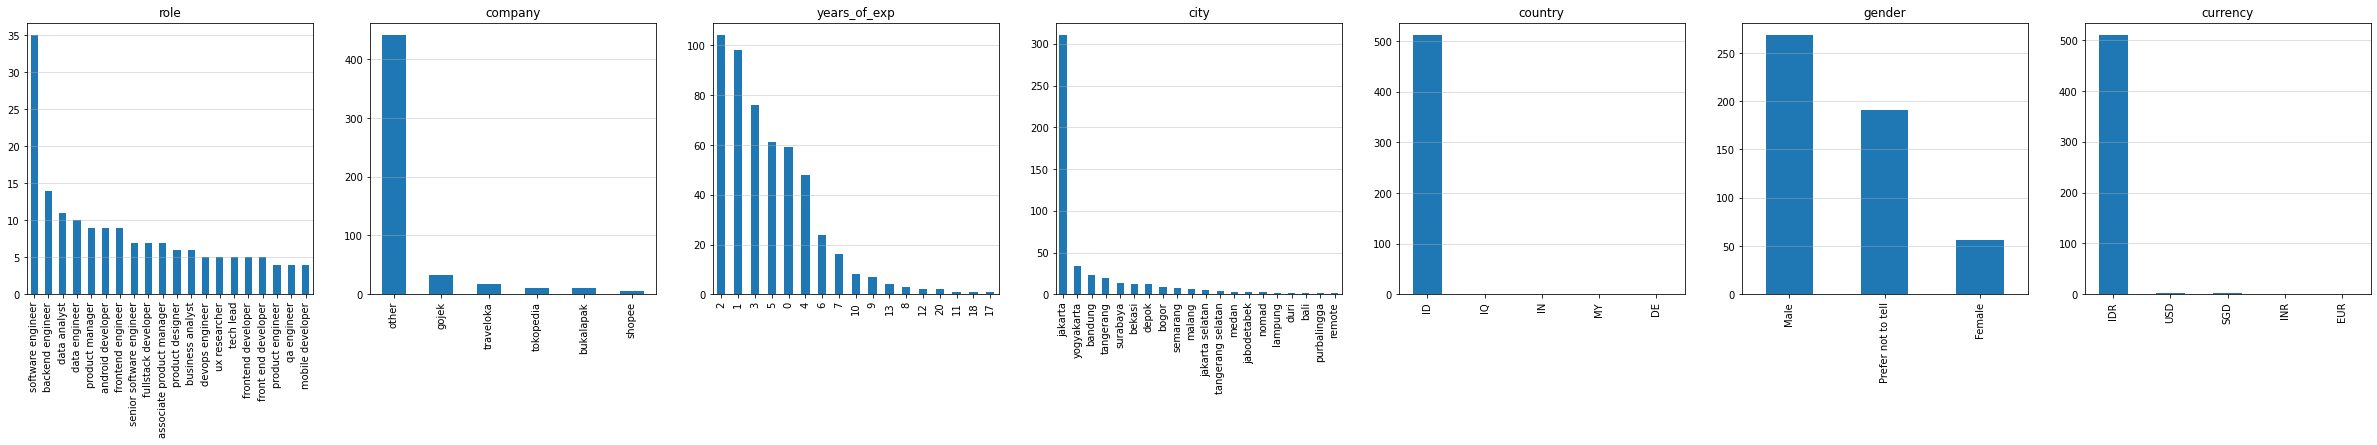

In [7]:
top = 20
figsize = (len(categorical_cols) * 6, 5)
fig, ax = plt.subplots(1, len(categorical_cols), figsize=figsize)

for i, col in enumerate(categorical_cols):
    temp_data = df[col].value_counts()[:top]
    temp_data.plot(kind='bar', ax=ax[i])
    ax[i].set_title(col)
    ax[i].grid(axis='y', alpha=0.5)

plt.show()

In terms of role and living city, software engineers and Jakarta highly surpass the other.

## How is the Distribution of the Salary? 🔔

As the only numerical column in the data, it's pretty basic to take a look at its distribution.

We look at its distribution as follows:
- The distribution as is
- Distribution based on gender, country, and company. However, since the `other` company is much more than the other, also take look at the distribution without the `other` company
- Distribution based on role, city, and years of exp. Since there are too many unique values, we only take the top 7 values for each of them

C:\Users\rerlan01\Desktop\temp_rimba\predict_salary\env\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


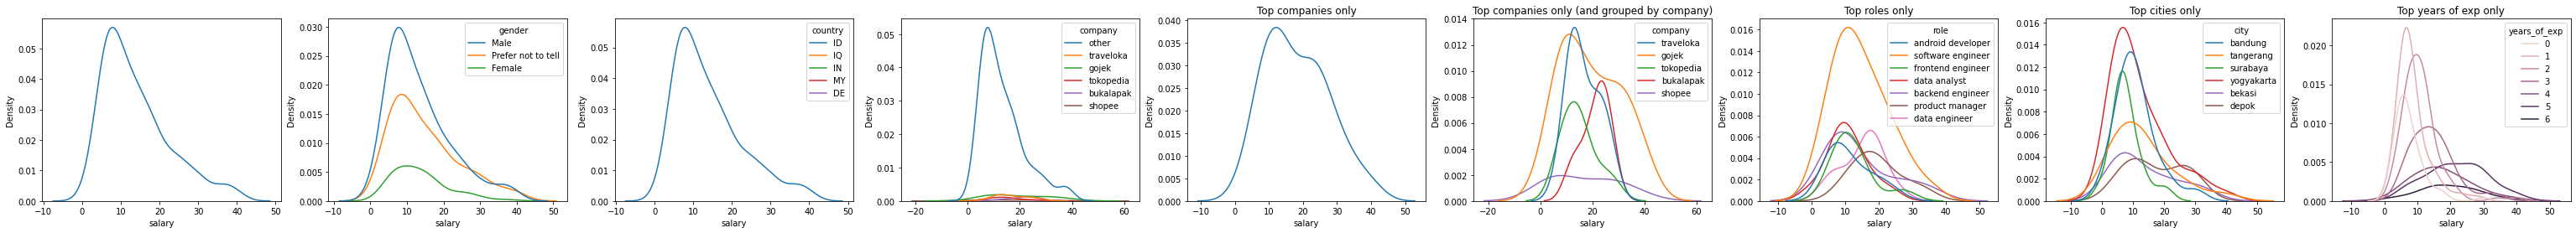

In [8]:
n_rows = 9
top = 7
fig, ax = plt.subplots(1, n_rows, figsize=(6 * n_rows, 4))

def kdeplot(data, ax, x='salary', hue=None, title=None):
    sns.kdeplot(x=x, data=data, ax=ax, hue=hue)
    ax.set_title(title)

kdeplot(ax=ax[0], data=df)
kdeplot(ax=ax[1], data=df, hue='gender')
kdeplot(ax=ax[2], data=df, hue='country')
kdeplot(ax=ax[3], data=df, hue='company')
kdeplot(ax=ax[4], data=df[df.company != 'other'],
        title='Top companies only')
kdeplot(ax=ax[5], hue='company', data=df[df.company != 'other'],
        title='Top companies only (and grouped by company)')
kdeplot(ax=ax[6], hue='role', title='Top roles only',
        data=df[df.role.isin(df.role.value_counts().index[:top])])
kdeplot(ax=ax[7], hue='city', title='Top cities only',
        data=df[df.city.isin(df.city.value_counts().index[1:top])])
top_yoe = df.years_of_exp.value_counts().index[:top]
kdeplot(ax=ax[8], hue='years_of_exp', title='Top years of exp only',
        data=df[df.years_of_exp.isin(top_yoe)])

plt.show()

It seems that the salary is not normally distributed if we take account the `other` company. But if we only consider the non-`other`s, the distribution is quite normal. Let's validate it using Kolmogorov-Smirnov test.

Null hypothesis: the data is normally distributed. Reject if p-value < 0.05.

In [9]:
salary = df.salary
print(kstest(salary, 'norm'))

salary_top_companies = df[df.company != 'other'].salary
print(kstest(salary_top_companies, 'norm'))

KstestResult(statistic=0.9801981016645152, pvalue=0.0)
KstestResult(statistic=0.9861832425242829, pvalue=6.784066324544314e-140)


Well, it turns out that statistically the salary is not normally distributed.

## How is the Correlation between Years of Exp and Salary? 📈

Years of experience and salary should be positively correlated. We can confirm this by looking at their scatter plot and correlation coefficient.

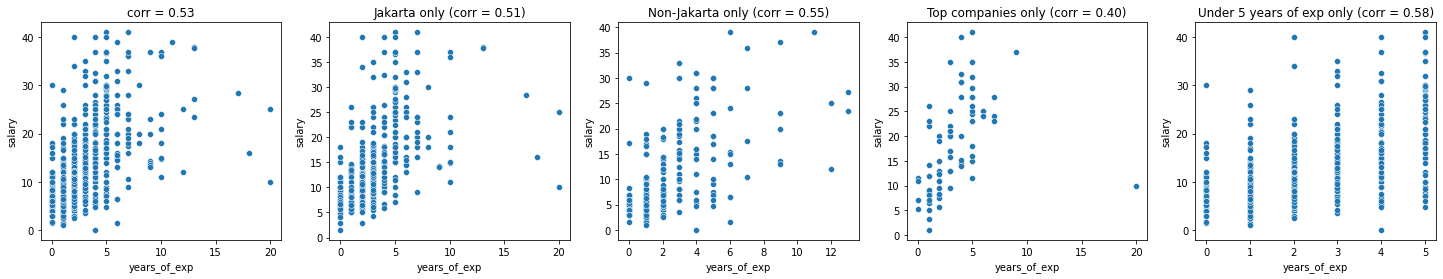

In [10]:
n_rows = 5
fig, ax = plt.subplots(1, n_rows, figsize=(5 * n_rows, 4))

def plot_scatter(data, ax, x='years_of_exp', y='salary', title=None):
    sns.scatterplot(data=data, x=x, y=y, ax=ax)
    
    corr = data[[x, y]].corr().loc[x, y]
    corr = f'corr = {corr:.2f}'
    title = title + f' ({corr})' if title != None else corr
    ax.set_title(title)

plot_scatter(ax=ax[0], data=df)
plot_scatter(ax=ax[1], data=df[df.city == 'jakarta'], title='Jakarta only')
plot_scatter(ax=ax[2], data=df[df.city != 'jakarta'], title='Non-Jakarta only')
plot_scatter(ax=ax[3], data=df[df.company != 'other'], title='Top companies only')
plot_scatter(ax=ax[4], data=df[df.years_of_exp <= 5], title='Under 5 years of exp only')

Each of them have somewhat positive correlation as expected, except for the chart for top companies only. This might be caused by that person with 20 years of experience.

In [11]:
df.query("(years_of_exp == 20) & (company != 'other')")

,role,company,years_of_exp,city,country,gender,currency,salary,mode,period,compensation,verified
362,machine learning engineer,tokopedia,20,jakarta,ID,Prefer not to tell,IDR,10.0,Net,Monthly,NaN,NaN


## Is There Any Difference in Salary for Employees with Above 10 Years of Exp and Below? 👨🏻‍💼

We wonder that is there any significant difference between the salary of employees with 10+ years of exp and those who are not. We utilize the T-test to check it.

Null hypothesis: there is no significant difference between them. Reject if p-value < 0.05.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:1.640e-07 t=-5.310e+00


(<AxesSubplot:xlabel='yoe_above_10', ylabel='salary'>,
 [<statannotations.Annotation.Annotation at 0x2bf898c1df0>])

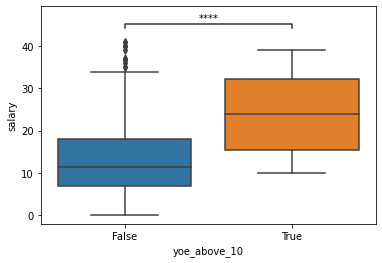

In [12]:
df['yoe_above_10'] = (df.years_of_exp >= 10).astype(str)
x, y = 'yoe_above_10', 'salary'
ax = sns.boxplot(data=df, x=x, y=y)

pairs = [('False', 'True')]
annotator = Annotator(ax, pairs, data=df, x=x, y=y)
annotator.configure(test='t-test_ind')
annotator.apply_and_annotate()

As we see, there is significant different between them, even without the statistical test and only by looking at the boxplot alone.

We can use this result to limit the years of exp values for the next modeling step.

## Is the Employee Gender Actually Affect Their Salary? ✨

We would also like to see that is there any significant difference of the salary between each employee gender? Let's do the same hypothesis testing.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Male vs. Prefer not to tell: t-test independent samples, P_val:7.844e-02 t=-1.764e+00
Prefer not to tell vs. Female: t-test independent samples, P_val:3.154e-01 t=1.006e+00
Male vs. Female: t-test independent samples, P_val:9.176e-01 t=-1.035e-01


(<AxesSubplot:xlabel='gender', ylabel='salary'>,
  <statannotations.Annotation.Annotation at 0x2bf898c1970>])

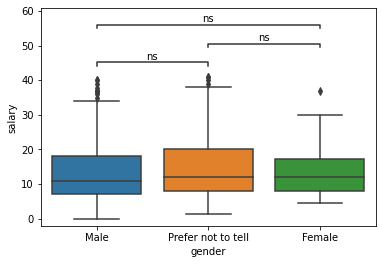

In [13]:
x, y = 'gender', 'salary'
ax = sns.boxplot(data=df, x=x, y=y)

pairs = [
    ('Male', 'Female'),
    ('Male', 'Prefer not to tell'),
    ('Female', 'Prefer not to tell')
]
annotator = Annotator(ax, pairs, data=df, x=x, y=y)
annotator.configure(test='t-test_ind')
annotator.apply_and_annotate()

Basically there is no significant difference of salary based on employee gender, indicated by their p-values
- M vs P: 0.07
- P vs F: 0.3
- F vs M: 0.9

that are larger than 0.05. This means we could just drop this feature during the modeling.

## How is The Salary of People Living around Jakarta? 🏢

Not all of people who work in Jakarta are actually living in Jakarta. They can be living in the area **around** in Jakarta, such as Bogor, Depok, Tangerang, and Bekasi. These area along with Jakarta are usually abbreviated as Jabodetabek.

We hypothesized that, the salary of people living around Jakarta are statistically the same as people living in Jakarta due to this reason. Again, we can utilize the T-test to prove this.

Null hypothesis: there is no significant difference of the salary for those who living in Jakarta and around Jakarta. Reject it if p-value < 0.05.

First let's see how the data looks like if we group them up.

In [14]:
df = clean_data(raw_data)
conditions_around_jkt = df.city.str.contains(
    'bogor|depok|tangerang|bekasi|jabotabek|jabodetabek'
)
conditions_jkt = (
    df.city.str.contains('jakarta')
    | (df.city == 'jakerta')
    | (df.city == 'jakara')
) & (df.city != 'jogjakarta')

df.loc[conditions_jkt, 'is_in_jakarta'] = 'yes'
df.loc[conditions_around_jkt, 'is_in_jakarta'] = 'around'
df.is_in_jakarta.fillna('no', inplace=True)

print('> In Jakarta:')
print(df[df.is_in_jakarta == 'yes'].city.value_counts())
print('> Around Jakarta:')
print(df[df.is_in_jakarta == 'around'].city.value_counts())

> In Jakarta:
jakarta            310
jakarta selatan      5
jakerta              1
jakarta barat        1
jakara               1
Name: city, dtype: int64
> Around Jakarta:
tangerang                      19
bekasi                         12
depok                          12
bogor                           9
tangerang selatan               4
jabodetabek                     3
kota bekasi                     1
south tangerang                 1
kabupaten bekasi (cikarang)     1
Name: city, dtype: int64


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

yes vs. around: t-test independent samples, P_val:3.593e-01 t=9.178e-01
no vs. yes: t-test independent samples, P_val:6.617e-10 t=-6.311e+00
no vs. around: t-test independent samples, P_val:6.492e-04 t=-3.466e+00


(<AxesSubplot:xlabel='is_in_jakarta', ylabel='salary'>,
  <statannotations.Annotation.Annotation at 0x2bf872ef760>])

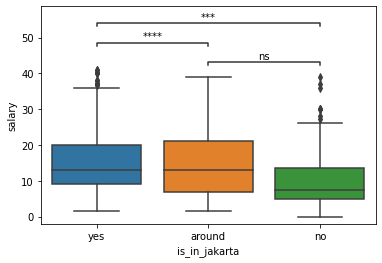

In [15]:
x, y = 'is_in_jakarta', 'salary'
ax = sns.boxplot(data=df, x=x, y=y, order=['yes', 'around', 'no'])

pairs = [('yes', 'around'), ('around', 'no'), ('yes', 'no')]
annotator = Annotator(ax, pairs, data=df, x=x, y=y)
annotator.configure(test='t-test_ind')
annotator.apply_and_annotate()

Gotcha! We got that the p-values
- Inside vs around Jakarta: 0.3
- Inside vs outside Jakarta: ~0.0
- Around vs outside Jakarta: ~0.0

indicating that actually, there is no significant difference of the salary between those who live in Jakarta and around Jakarta. Therefore, we can set the people living around Jakarta **as same** with people living inside Jakarta in the modeling.

## Is There Any Difference in Salary for Employees Living in Indonesia or Not? 🇮🇩

We would like to prove this hypothesis with statistical test as well.

Null hypothesis: there is no significant difference of the salary for those who living in Indonesia and not. Reject it if p-value < 0.05.

We can take a look of the distribution first.

In [16]:
df.country = df.apply(clean_country, axis=1)
df.country.value_counts()

ID            511
Outside ID      4
Name: country, dtype: int64

Pretty low number of samples for people living outside ID.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ID vs. Outside ID: t-test independent samples, P_val:4.613e-01 t=7.373e-01


(<AxesSubplot:xlabel='country', ylabel='salary'>,
 [<statannotations.Annotation.Annotation at 0x2bf87286a60>])

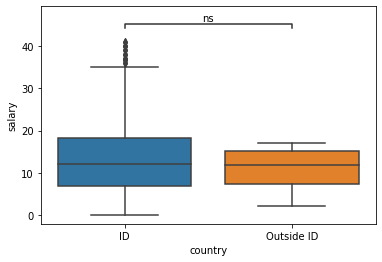

In [17]:
x, y = 'country', 'salary'
ax = sns.boxplot(data=df, x=x, y=y)

pairs = [('ID', 'Outside ID')]
annotator = Annotator(ax, pairs, data=df, x=x, y=y)
annotator.configure(test='t-test_ind')
annotator.apply_and_annotate()

Well, there is no significant difference statistically. This might due to the low number of samples of people living outside Indonesia. By this, we decide to drop this feature during the modeling.

# Modeling 🤓

## Baseline: CatBoost 😸

CatBoost is very well suited algorithm for this data, since most of the features are categorical.

First, let's build a baseline model with the data as is (only with basic cleaning and no feature engineering). Afterwards we do feature engineering and see if it will beat the baseline model in terms of score.

**Metrics**

We use RMSE as our metrics here, and say the model is "good" if it has RMSE of less than 1 (remember that we divide the salary with 1M, so this actually means IDR 1M in error). This is because we can interpret RMSE as the average deviations between the actual and the predicted salary, and an error of more than 1 (million) is still too high and can not be tolerated.

The specific reason why we choose RMSE instead of MAE (though they both can be interpreted the same -- average deviations), is because we want to penalize more the error, and RMSE is suitable of it over MAE. Note that the RMSE below is shown as negative since we would like to set the task as maximization.

**Workaround**

Let's also do the hyperparameter tuning of our CatBoost model with the help of Optuna library along with 5-fold cross-validation. Click the config below to see the configurations.

### Config

In [18]:
# config
seed = 0
early_stopping_rounds = 200
n_splits = 5
n_trials = 10
timeout = 60
verbose = 0
direction = 'maximize'

rmse = lambda y_true, y_pred: np.sqrt(mse(y_true, y_pred))
scoring = make_scorer(rmse, greater_is_better=False)

cv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
fit_params = dict(early_stopping_rounds=early_stopping_rounds, verbose=verbose)
cv_params = dict(cv=cv, fit_params=fit_params, scoring=scoring)

def get_params_func(one_hot_max_size_choice):
    def params_func(trial):
        param = {
            "depth": trial.suggest_int("depth", 1, 10),
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
            "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-3, 1e0),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
            "one_hot_max_size": trial.suggest_categorical(
                "one_hot_max_size", one_hot_max_size_choice
            ),
            "colsample_bylevel": trial.suggest_float(
                "colsample_bylevel", 0.01, 0.1
            ),
            "boosting_type": trial.suggest_categorical(
                "boosting_type", ["Ordered", "Plain"]
            ),
            "bootstrap_type": trial.suggest_categorical(
                "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
            )
        }

        # Conditional Hyper-Parameters
        if param["bootstrap_type"] == "Bayesian":
            param["bagging_temperature"] = trial.suggest_float(
                "bagging_temperature", 0, 10
            )
        elif param["bootstrap_type"] == "Bernoulli":
            param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

        return param
    return params_func

### Training

In [19]:
print('\nBaseline model')
df = clean_data(raw_data)

feature_cols = np.array(['role', 'company', 'city', 'country',
                         'gender', 'years_of_exp'])
cat_features = [0, 1, 2, 3, 4]
X, y = df[feature_cols], df.salary
print('Data shape:', X.shape)

one_hot_max_size_choice = sorted(df[feature_cols[cat_features]].nunique())
params_func = get_params_func(one_hot_max_size_choice)
clf_params = dict(cat_features=cat_features, random_seed=seed)

best_params, study = tune_catboost_cv(
    X, y, params_func, seed=seed, n_trials=n_trials, timeout=timeout,
    cv_params=cv_params, clf_params=clf_params, direction=direction
)


Baseline model
Data shape: (515, 6)
> Number of completed trials: 7
> Finished in: 63.6s (9.1s/trial)
> Best Params: 
{
    "depth": 1,
    "learning_rate": 0.14557916623227773,
    "l2_leaf_reg": 0.2160082074140204,
    "min_data_in_leaf": 18,
    "one_hot_max_size": 3,
    "colsample_bylevel": 0.06759289191947715,
    "boosting_type": "Plain",
    "bootstrap_type": "Bayesian",
    "bagging_temperature": 7.742336894342166
}
> Best Score: -6.600076230691658


Now let's see if our feature engineering helps.

## Feature Engineering 🔧

### Apply the Exploration Result

Let's apply our result of data exploration as a feature engineering:
- Set employees with 10 or more years of experience as `10+`
- Do not use `gender` and `country` feature
- Set people living around Jakarta as living inside Jakarta

In [20]:
print('\nAfter feature engineering')
df = clean_data(raw_data)
df.city = df.apply(clean_city, axis=1)
df.years_of_exp = df.apply(limit_years_of_exp, axis=1, limit=10)

feature_cols = ['role', 'company', 'city', 'years_of_exp']
cat_features = range(len(feature_cols))
X, y = df[feature_cols], df.salary
print('Data shape:', X.shape)

one_hot_max_size_choice = sorted(df[feature_cols].nunique())
params_func = get_params_func(one_hot_max_size_choice)
clf_params = dict(cat_features=cat_features, random_seed=seed)

best_params, study = tune_catboost_cv(
    X, y, params_func, seed=seed, n_trials=n_trials, timeout=timeout,
    cv_params=cv_params, clf_params=clf_params, direction=direction
)


After feature engineering
Data shape: (515, 4)
> Number of completed trials: 10
> Finished in: 35.9s (3.6s/trial)
> Best Params: 
{
    "depth": 4,
    "learning_rate": 0.2543993430977455,
    "l2_leaf_reg": 0.05543941231681779,
    "min_data_in_leaf": 18,
    "one_hot_max_size": 293,
    "colsample_bylevel": 0.06795911793066738,
    "boosting_type": "Plain",
    "bootstrap_type": "MVS"
}
> Best Score: -6.644250847034337


### Bag of Words: `role`

Instead of directly treat the `role` feature as categorical, let's see what's the result if we treat them as text instead.

We can use bag of words model to get the vocabulary of the job roles, and vectorize a role depending on the presence of each token in the vocabulary.

In [21]:
print('\nBag of words: `role`')
df = clean_data(raw_data)
df.city = df.apply(clean_city, axis=1)
df.role = df.apply(clean_role, axis=1)
df.years_of_exp = df.apply(limit_years_of_exp, axis=1, limit=10)

# extract token count
vec = CountVectorizer(binary=True)
vec.fit(df.role)
counts = pd.DataFrame(
    vec.transform(df.role).toarray(),
    columns=vec.get_feature_names_out()
)

# prepare data
cols = ['company', 'city', 'years_of_exp']
X, y = pd.concat([counts, df[cols]], axis=1), df.salary
cat_features = range(len(X.columns))
print('Data shape:', X.shape)

# start training
one_hot_max_size_choice = list(set(X.nunique()))
params_func = get_params_func(one_hot_max_size_choice)
clf_params = dict(cat_features=cat_features, random_seed=seed)

best_params, study = tune_catboost_cv(
    X, y, params_func, seed=seed, n_trials=n_trials, timeout=timeout,
    cv_params=cv_params, clf_params=clf_params, direction=direction
)


Bag of words: `role`
Data shape: (515, 222)
> Number of completed trials: 8
> Finished in: 70.4s (8.8s/trial)
> Best Params: 
{
    "depth": 3,
    "learning_rate": 0.04742093476950261,
    "l2_leaf_reg": 0.770132826493912,
    "min_data_in_leaf": 6,
    "one_hot_max_size": 11,
    "colsample_bylevel": 0.09574741103652866,
    "boosting_type": "Plain",
    "bootstrap_type": "MVS"
}
> Best Score: -6.535353336101065
